In [8]:
# -*- coding: utf-8 -*-
# Auto-merged: capstone_group4.py + RF.py (imports unified; functionality preserved)

from __future__ import annotations
import numpy as np
import pandas as pd
from typing import List, Dict, Union, Optional
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time; time.sleep(0.5)
from combined_capstone_RF import (
    load_and_inspect_data, #LR begin
    perform_linear_regression_analysis, #end
    make_salary_tiers, #DT begin 
    infer_feature_columns,
    train_decision_tree_classifier,
    train_decision_tree_classifier_simple,
    plot_confusion,
    plot_tree_structure,
    export_tree_rules,
    top_k_features_by_importance, #end
    random_forest, # RF begin    
)

# ---- capstone_groupXX.ipynb ----

# MLB 投手薪资等级分类（Decision Tree）Notebook 模板

逐格运行，便于调试与提交草稿。

In [9]:
%load_ext autoreload
%autoreload 2

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. 导入依赖与脚本函数

## 2. 读取数据（修改路径即可）

In [10]:
DATA_PATH = "mlb_salaries_and_pitching_stats_2011-2024.csv"
df = pd.read_csv(DATA_PATH)
len(df), df.shape

(21094, (21094, 18))

## 3. 快速窥视数据结构

In [11]:
sorted(df.columns.tolist())

['BB',
 'ER',
 'ERA',
 'G',
 'GS',
 'H',
 'HR',
 'IP',
 'L',
 'Player',
 'Player_Stats_Match',
 'R',
 'SO',
 'Total Cash',
 'W',
 'WAR',
 'WHIP',
 'Year']

In [12]:
df.head(3)

,Player,Year,Total Cash,Player_Stats_Match,WAR,W,L,G,GS,IP,H,R,ER,HR,BB,SO,ERA,WHIP
0,Kenley Jansen,2024,16000000,Kenley Jansen,1.3,4.0,2.0,54.0,0.0,54.2,38.0,20.0,20.0,4.0,20.0,62.0,3.29,1.061
1,Edwin Diaz,2024,11750000,Edwin Díaz,0.5,6.0,4.0,54.0,0.0,53.2,36.0,23.0,21.0,7.0,20.0,84.0,3.52,1.043
2,Chad Green,2024,10500000,Chad Green,0.7,4.0,6.0,53.0,0.0,53.1,41.0,20.0,19.0,8.0,14.0,46.0,3.21,1.031


In [13]:
df.dtypes

Player                 object
Year                    int64
Total Cash              int64
Player_Stats_Match     object
WAR                   float64
W                     float64
L                     float64
G                     float64
GS                    float64
IP                    float64
H                     float64
R                     float64
ER                    float64
HR                    float64
BB                    float64
SO                    float64
ERA                   float64
WHIP                  float64
dtype: object

## 4. 生成薪资分层（tiers）

In [14]:
df = make_salary_tiers(df, salary_col="Total Cash", n_tiers=4)
df["salary_tier"].value_counts(dropna=False)

salary_tier
T1    5275
T2    5274
T4    5274
T3    5271
Name: count, dtype: int64

## 5. EDA：缺失与分布概览

In [15]:
(df.isna().mean().sort_values(ascending=False)).head(20)

ERA                   0.408126
WHIP                  0.408126
Player_Stats_Match    0.407794
H                     0.407794
IP                    0.407794
R                     0.407794
WAR                   0.407794
G                     0.407794
GS                    0.407794
W                     0.407794
L                     0.407794
BB                    0.407794
HR                    0.407794
SO                    0.407794
ER                    0.407794
Total Cash            0.000000
Year                  0.000000
Player                0.000000
salary_tier           0.000000
dtype: float64

In [16]:
df.describe(include="all").T.head(20)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Player,21094,3788,David Carpenter,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,21094.0,NaN,NaN,NaN,2017.588129,3.805154,2011.0,2015.0,2018.0,2021.0,2024.0
Total Cash,21094.0,NaN,NaN,NaN,2445882.754575,4596457.986889,2732.0,233885.0,552024.0,2262448.75,55000000.0
Player_Stats_Match,12492,2254,David Carpenter,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WAR,12492.0,NaN,NaN,NaN,0.562056,1.214501,-2.5,-0.1,0.2,1.0,9.7
W,12492.0,NaN,NaN,NaN,3.117115,3.70281,0.0,0.0,2.0,4.0,24.0
L,12492.0,NaN,NaN,NaN,3.139609,3.395011,0.0,0.0,2.0,5.0,19.0
G,12492.0,NaN,NaN,NaN,27.409062,20.401835,1.0,11.0,24.0,38.0,85.0
GS,12492.0,NaN,NaN,NaN,6.057157,10.029239,0.0,0.0,0.0,9.0,35.0
IP,12492.0,NaN,NaN,NaN,55.268412,52.188924,0.0,17.2,40.1,69.2,251.0


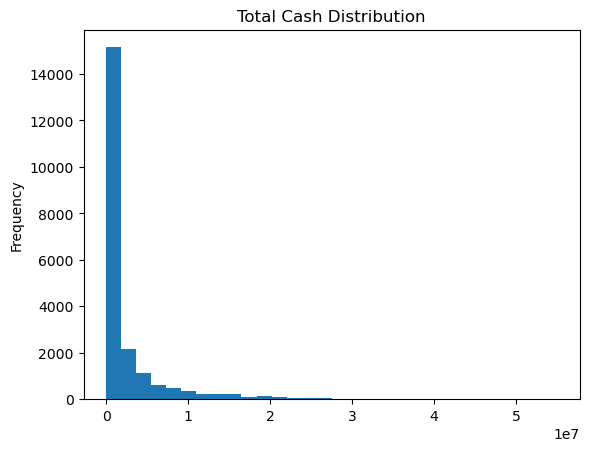

In [17]:
df["Total Cash"].plot(kind="hist", bins=30, title="Total Cash Distribution")
plt.show()

## 6. 选择特征列（自动 + 手动微调）

In [18]:
feature_cols = infer_feature_columns(df, target_col="salary_tier")
feature_cols

['WAR',
 'W',
 'L',
 'G',
 'GS',
 'IP',
 'H',
 'R',
 'ER',
 'HR',
 'BB',
 'SO',
 'ERA',
 'WHIP']

In [19]:
# 手动微调（例如不使用 Year）
feature_cols = [c for c in feature_cols if c not in ["Year"]]
feature_cols

['WAR',
 'W',
 'L',
 'G',
 'GS',
 'IP',
 'H',
 'R',
 'ER',
 'HR',
 'BB',
 'SO',
 'ERA',
 'WHIP']

## 7. 训练 & 调参（决策树）

In [20]:
model, (X_test, y_test, y_pred), summary = train_decision_tree_classifier_simple(
    df, feature_cols, target_col="salary_tier",
    base_max_depth=6, base_min_samples_leaf=10, search_alphas=20
)
print(summary["constraints"], "chosen_alpha:", summary["chosen_ccp_alpha"])
print("CV f1_macro:", summary["cv_best_score"])
print("Holdout Acc:", summary["holdout_accuracy"])
print("Holdout F1_macro:", summary["holdout_f1_macro"])
print(summary["classification_report"])

{'max_depth': 6, 'min_samples_leaf': 10} chosen_alpha: 0.0
CV f1_macro: 0.37312557871833646
Holdout Acc: 0.4088646598720076
Holdout F1_macro: 0.3895798909175519
              precision    recall  f1-score   support

          T1      0.588     0.457     0.514      1055
          T2      0.424     0.194     0.266      1055
          T3      0.396     0.255     0.310      1054
          T4      0.344     0.729     0.467      1055

    accuracy                          0.409      4219
   macro avg      0.438     0.409     0.390      4219
weighted avg      0.438     0.409     0.390      4219



## 8. 评估指标与可视化

In [21]:
print("约束(限深/叶子)：", summary["constraints"])
print("选择的 ccp_alpha：", summary["chosen_ccp_alpha"])
print("CV f1_macro：", summary["cv_best_score"])
print("Holdout Accuracy：", summary["holdout_accuracy"])
print("Holdout F1_macro：", summary["holdout_f1_macro"])
print(summary["classification_report"])

约束(限深/叶子)： {'max_depth': 6, 'min_samples_leaf': 10}
选择的 ccp_alpha： 0.0
CV f1_macro： 0.37312557871833646
Holdout Accuracy： 0.4088646598720076
Holdout F1_macro： 0.3895798909175519
              precision    recall  f1-score   support

          T1      0.588     0.457     0.514      1055
          T2      0.424     0.194     0.266      1055
          T3      0.396     0.255     0.310      1054
          T4      0.344     0.729     0.467      1055

    accuracy                          0.409      4219
   macro avg      0.438     0.409     0.390      4219
weighted avg      0.438     0.409     0.390      4219



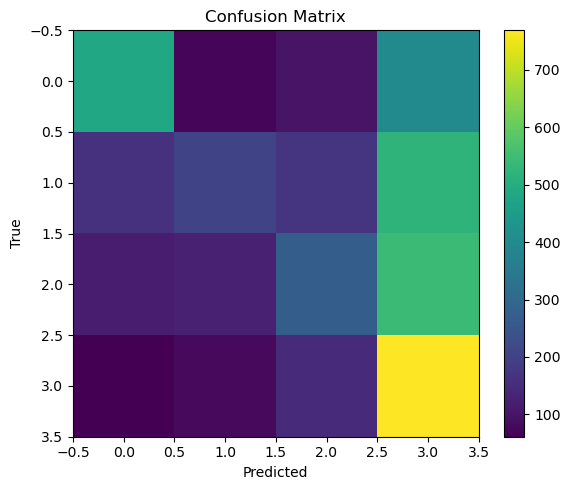

In [22]:
plot_confusion(y_test, y_pred)  # 可改 normalize='true'

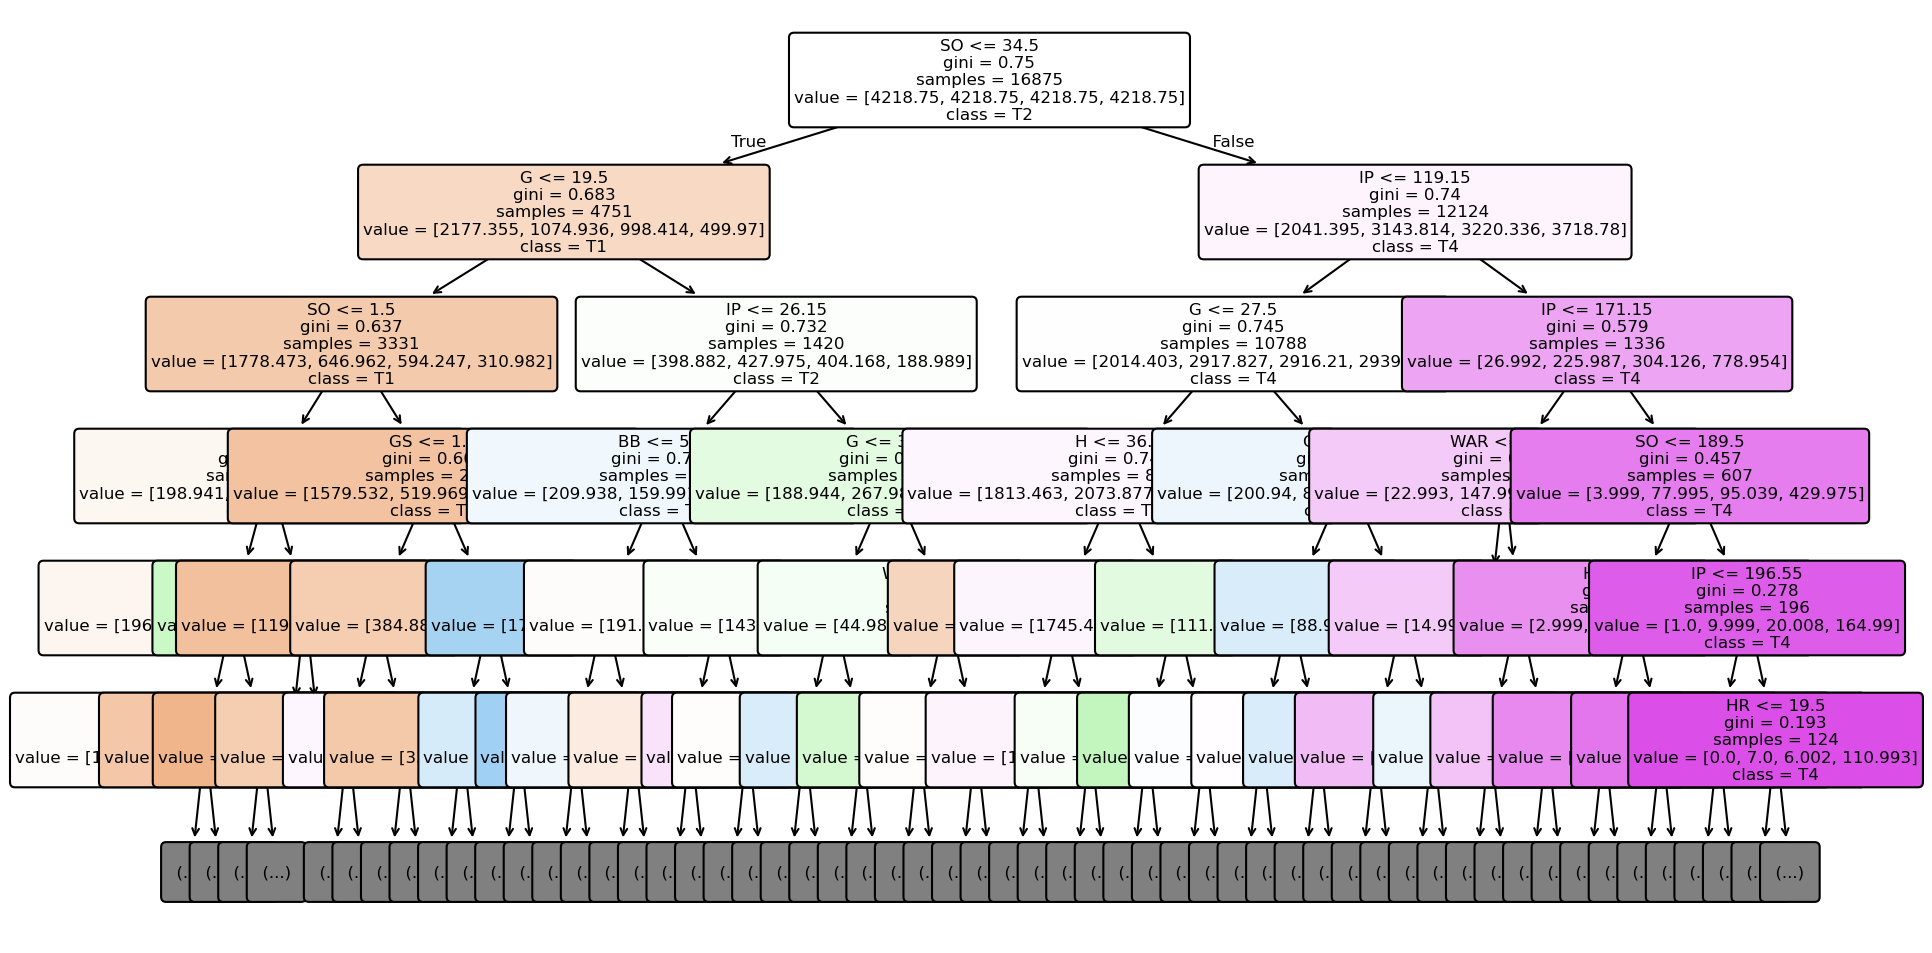

In [23]:
plot_tree_structure(model, feature_cols, max_depth_to_plot=5)

## 9. 特征重要性（可选）

In [24]:
clf = model.named_steps["clf"]
importances = clf.feature_importances_
imp_df = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values("importance", ascending=False)
imp_df.head(15)

,feature,importance
11,SO,0.415869
3,G,0.216589
5,IP,0.203340
13,WHIP,0.031605
6,H,0.028530
4,GS,0.019368
10,BB,0.019306
12,ERA,0.016622
9,HR,0.014242
8,ER,0.014165


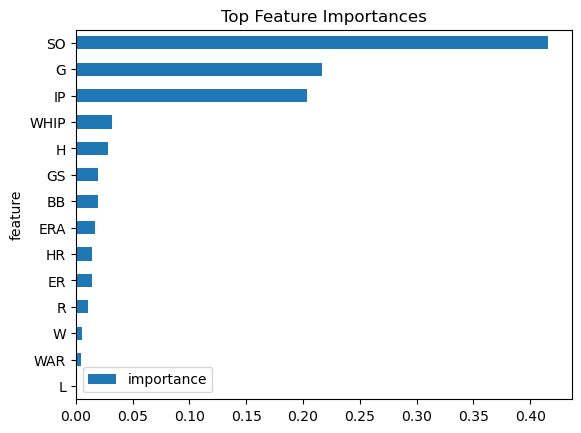

In [25]:
ax = imp_df.head(15).plot(kind="barh", x="feature", y="importance", title="Top Feature Importances")
ax.invert_yaxis()

## 10. 保存模型（可选）

In [27]:
import joblib
joblib.dump(model, "salary_tier_tree_pipeline.joblib")

['salary_tier_tree_pipeline.joblib']

## 11. 推理示例（可选）

In [29]:
sample = df.sample(5, random_state=42)
pred = model.predict(sample[feature_cols])
sample_out = pd.DataFrame({
    "Player": sample.get("Player", pd.Series([None]*len(sample))),
    "TrueTier": sample["salary_tier"].values,
    "PredTier": pred
})
sample_out

,Player,TrueTier,PredTier
6206,Ji-Man Choi,T2,T4
2041,Spencer Steer,T3,T4
13544,Tyler Thornburg,T2,T3
4985,Travis Shaw,T2,T4
13290,Zach Duke,T3,T3


# ---- RF.ipynb ----

C:\Users\p0905\Downloads\combined_capstone_RF.py:372: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mlb_df[col].fillna(mlb_df[col].median(), inplace=True)
C:\Users\p0905\Downloads\combined_capstone_RF.py:373: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

Results
Training Accuracy: 0.8457691376946035
Testing Accuracy: 0.8351612903225807

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2325
           1       0.65      0.74      0.69       775

    accuracy                           0.84      3100
   macro avg       0.78      0.80      0.79      3100
weighted avg       0.84      0.84      0.84      3100



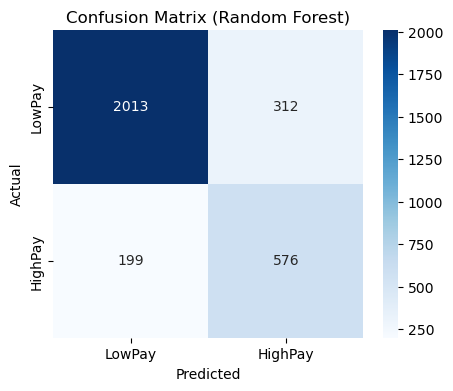

C:\Users\p0905\Downloads\combined_capstone_RF.py:460: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')


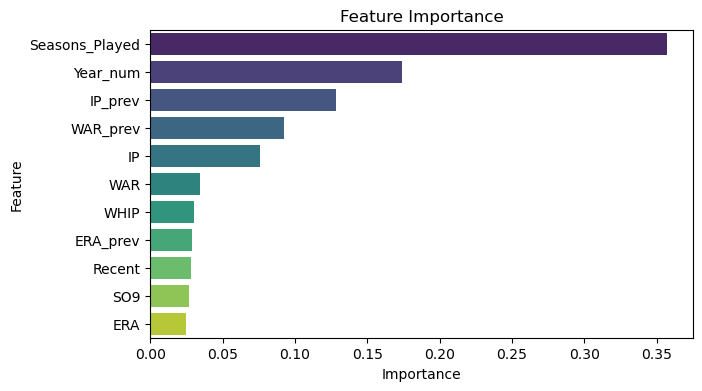


Top Feature Importance:
            Feature  Importance
7   Seasons_Played    0.357038
5         Year_num    0.173841
9          IP_prev    0.128160
8         WAR_prev    0.092220
2               IP    0.076032
0              WAR    0.034584
4             WHIP    0.030501
10        ERA_prev    0.028525
6           Recent    0.028175
3              SO9    0.026574
1              ERA    0.024350

Analysis complete.


In [30]:
mlb_df = pd.read_csv("mlb_salaries_and_pitching_stats_2011-2024.csv")
random_forest(mlb_df)
print("\nAnalysis complete.")

# ---- capstone_group4.ipynb ----

--- 1. Data Loading and Inspection ---
Data loaded successfully.
Shape of the dataset: (21094, 18)

First 5 rows:
          Player  Year  Total Cash Player_Stats_Match  WAR    W    L     G   GS    IP     H     R    ER   HR    BB    SO   ERA   WHIP
0  Kenley Jansen  2024    16000000      Kenley Jansen  1.3  4.0  2.0  54.0  0.0  54.2  38.0  20.0  20.0  4.0  20.0  62.0  3.29  1.061
1     Edwin Diaz  2024    11750000         Edwin Díaz  0.5  6.0  4.0  54.0  0.0  53.2  36.0  23.0  21.0  7.0  20.0  84.0  3.52  1.043
2     Chad Green  2024    10500000         Chad Green  0.7  4.0  6.0  53.0  0.0  53.1  41.0  20.0  19.0  8.0  14.0  46.0  3.21  1.031
3    Paul Sewald  2024     7350000        Paul Sewald  0.2  1.0  2.0  42.0  0.0  39.2  35.0  19.0  19.0  6.0  10.0  43.0  4.31  1.134
4   Jose Leclerc  2024     6250000       José Leclerc  0.0  6.0  5.0  64.0  0.0  66.2  56.0  33.0  32.0  7.0  32.0  89.0  4.32  1.320

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21094 entries, 0 to

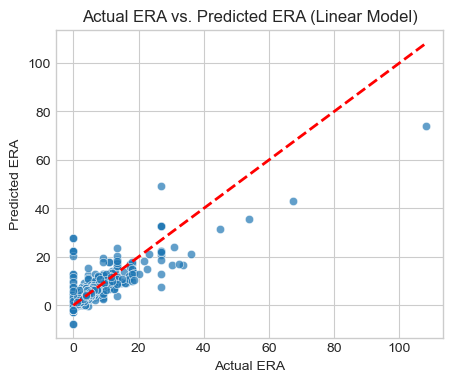


Analysis complete.


In [31]:
# --- Main excution ---
if __name__ == '__main__':
    # Chart type
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Define file path
    file_path = 'mlb_salaries_and_pitching_stats_2011-2024.csv'
    
    # Step 1-Load data and inspect data
    main_df = load_and_inspect_data(file_path)
    
    # Step 2- if success, run regression model
    if main_df is not None:
        perform_linear_regression_analysis(main_df)
        print("\nAnalysis complete.")